In [16]:
import pandas as pd
import numpy as np
import pickle
import scipy.constants as phy_const
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import os
import glob
import sys
import configparser

import MakePlots_Charoy as mplt_mod
import FLHET_compiled
from modules.simu_params import SimuParameters


# Extraction of the fluid results

In [17]:
fluid_dir   = "./Results/charoy_checkcase_0_N400_no_hflux_no_coll"

unvariant_data_file     = fluid_dir + "/Data/MacroscopicUnvariants.pkl"
steady_stat_file        = fluid_dir + "/Data/MacroscopicVars_000044.pkl"
steady_state_file_m1    = fluid_dir + "/Data/MacroscopicVars_000043.pkl"

with open(unvariant_data_file, 'rb') as f:
    [Barr, x_mesh, x_center, alpha_B] = pickle.load(f)
with open(steady_stat_file, 'rb') as f:
    [t, P, U, P_Inlet, P_Outlet, J, Efield] = pickle.load(f)

with open(steady_state_file_m1, 'rb') as f:
    [tm1, Pm1, _, _, _, _, _] = pickle.load(f)

msp     = SimuParameters(fluid_dir + "/Configuration.cfg")

LTHR    = msp.LTHR
ESTAR   = msp.ESTAR
wall_inter_type     = msp.wall_inter_type
R1  = msp.R1
R2  = msp.R2
Mi  = msp.Mi
KEL = msp.KEL

NBPOINTS = np.shape(x_center)[0]

Default Magnetic Field
The ionization source term is imposed as specified in T.Charoy's thesis, section 2.2.2.


# Plot variables

In [97]:
tickfontsize    = 16
legendfontsize  = 15
axisfontsize    = 19
titlefontsize   = 21

# Comparison with the PIC data from F.P. comparison of $R_{ei}$  and energy terms

In [19]:
extracted_df = pd.read_csv("./Inputs/PIC_data_FP/20240724_PIC_ext_df.csv", sep="\t", header=0)
print(extracted_df.columns)

Index(['Unnamed: 0', 'x', 'EE', 'n_e', 'corr_term_y', 'corr_term_x', 've_y',
       've_x', 'Te_x', 'Te_y', 'BB', 'dEy_2', 'dJy_dEy'],
      dtype='object')


## Comparison of force density terms, azimuthal projection

Notation from Charoy's thesis Chapter 4:
$$
- F_{B,x} = F_{t,x} + F_{in,x} + F_{p,x} + F_{E,x} + R_{en,x} + R_{ei,x}
$$

But this notation is not so conveninient and unintuitive let's rather write:
$$
\partial_t(m_e n_e \mathbf{u_e}) + \nabla \cdot \left[ m_e n_e \mathbf{u_e}\mathbf{u_e} \right] = -e n_e \mathbf{E} -e n_e \mathbf{u_e} \times \mathbf{B} - \nabla \cdot \bar{\bar{P_e}} + F_{en} + F_{ei}
$$

or introducing the following notation:
$$
\partial_t(m_e n_e \mathbf{u_e}) + \nabla \cdot \left[ m_e n_e \mathbf{u_e}\mathbf{u_e} \right] = \mathbf{F_{E}} + \mathbf{F_{B}} + \mathbf{F_{P}} + \mathbf{F_{en}} + \mathbf{F_{ei}}
$$

In [84]:
ng  = P[0, :]
ni  = P[1, :]
uix = P[2, :]
Te  = P[3, :]
uex = P[4, :]

w_ce    = phy_const.e * Barr / phy_const.m_e
nu_eff  = alpha_B * w_ce

uey = (w_ce / nu_eff) * uex

In [85]:
Rei_emp_y     = mplt_mod.compute_Rei_empirical(P, Barr, ESTAR, wall_inter_type, R1, R2, Mi, x_center, LTHR, KEL, alpha_B)
F_in_y  = np.gradient(phy_const.m_e * ni * uex * uey, x_center)
F_t_y   = phy_const.m_e * (ni*uey - Pm1[1, :]* (w_ce / nu_eff) * Pm1[4, :])/(t - tm1)
Rei_sat_arr     = mplt_mod.compute_Rei_saturated(P, Mi, x_center)
F_B_y   = phy_const.e * ni * Barr * uex
RHS_y     = Rei_emp_y + F_B_y
LHS_y      = F_t_y + F_in_y

In [86]:
PIC_Rei_y   = extracted_df['corr_term_y']
PIC_F_in_y  = np.gradient(phy_const.m_e * extracted_df['n_e'] * extracted_df['ve_x'] * extracted_df['ve_y'], extracted_df['x']/100)

# plot digitized figure 4.1 in Charoy's thesis.
PIC_F_in_y  = np.loadtxt("./Results_to_share/plot_digitizer_from_Charoy/F_in_y.csv", converters = (lambda s: float(s.decode("UTF-8").replace(",", "."))), delimiter=";")
function_interp   = interpolate.interp1d(PIC_F_in_y[:,0], PIC_F_in_y[:,1])
PIC_F_in_y   = -function_interp(extracted_df['x'])

PIC_F_P_y   = np.loadtxt("./Results_to_share/plot_digitizer_from_Charoy/F_Py.csv", converters = (lambda s: float(s.decode("UTF-8").replace(",", "."))), delimiter=";") 
function_interp   = interpolate.interp1d(PIC_F_P_y[:,0], PIC_F_P_y[:,1])
PIC_F_P_y   = function_interp(extracted_df['x'])
PIC_E_y     = np.loadtxt("./Results_to_share/plot_digitizer_from_Charoy/F_E_y.csv", converters = (lambda s: float(s.decode("UTF-8").replace(",", "."))), delimiter=";")
function_interp   = interpolate.interp1d(PIC_E_y[:,0], PIC_E_y[:,1])
PIC_E_y     = -function_interp(extracted_df['x'])

PIC_F_B_y   = phy_const.e * extracted_df['n_e'] * extracted_df['BB']*100 * extracted_df['ve_x']
PIC_RHS_y   = PIC_Rei_y + PIC_F_B_y + PIC_F_P_y + PIC_E_y
PIC_LHS_y   = PIC_F_in_y + 0.

Plot have proved that magnetic_term = Rei_emp_arr. That is logic since in the fluid code we ignored all other terms in the momentum $e^-$ equation along the azimuthal axis.

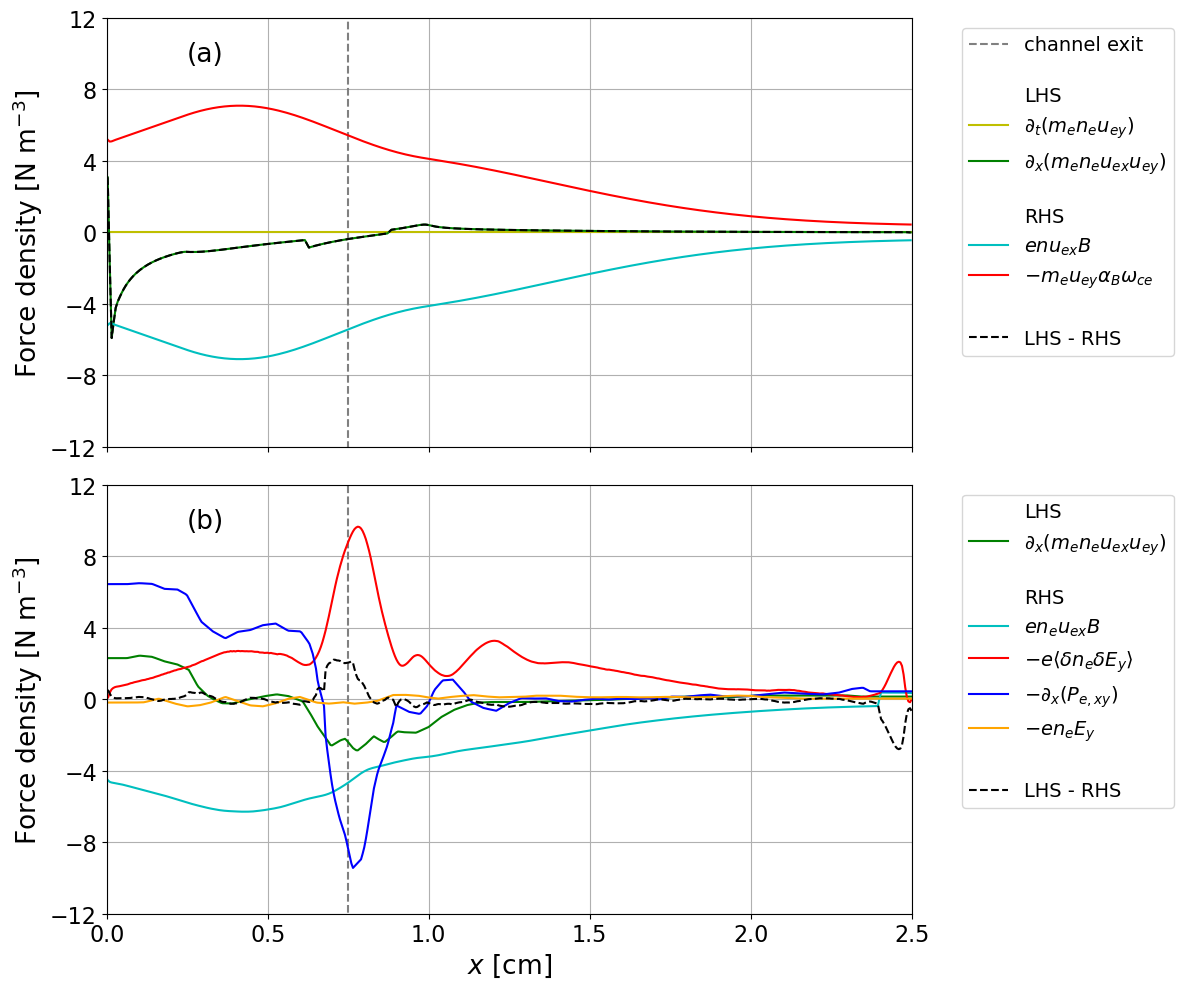

In [101]:
f, ax = plt.subplots(2, 1, figsize=(12,10))

ax[0].plot([LTHR*100, LTHR*100], [-2000., 2000.], '--', color='grey', label='channel exit')
ax[0].plot([], [], ' ', label="\nLHS")
ax[0].plot(x_center*100, F_t_y, 'y-', label = "$\\partial_t (m_e n_e u_{ey})$")
ax[0].plot(x_center*100, F_in_y, 'g-', label = "$\\partial_x (m_e n_e u_{ex} u_{ey})$")
ax[0].plot([], [], ' ', label="\nRHS")
ax[0].plot(x_center*100, F_B_y, 'c-', label = "$e n u_{ex} B$")
ax[0].plot(x_center*100, Rei_emp_y, 'r-', label = "$-m_e u_{ey} \\alpha_{B} \\omega_{ce}$")
ax[0].plot([], [], ' ', label=" ")
ax[0].plot(x_center*100, LHS_y-RHS_y, 'k--', label = "LHS - RHS")
ax[0].set_yticks([-12., -8.0, -4.0, 0., 4.0, 8.0, 12.0])
ax[0].set_ylim([-12., 12.])
ax[0].set_xlim([0., 2.5])
ax[0].set_xticklabels([])
ax[0].yaxis.set_tick_params(labelsize=tickfontsize)
ax[0].set_ylabel("Force density [N m$^{-3}$]", fontsize=axisfontsize)
ax[0].xaxis.set_tick_params(labelsize=tickfontsize)
ax[0].yaxis.set_tick_params(labelsize=tickfontsize)
ax[0].grid()
ax[0].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize-1)
ax[0].text(0.25, 9.6, '(a)', fontsize=axisfontsize)

ax[1].plot([LTHR*100, LTHR*100], [-2000., 2000.], '--', color='grey')
ax[1].plot([], [], ' ', label="LHS")
ax[1].plot(extracted_df['x'], PIC_F_in_y, 'g-', label = "$\\partial_x (m_e n_e u_{ex} u_{ey})$")
ax[1].plot([], [], ' ', label="\nRHS")
ax[1].plot(extracted_df['x'], PIC_F_B_y, 'c-', label = "$e n_e u_{ex} B$")
ax[1].plot(extracted_df['x'], PIC_Rei_y, 'r-', label = "$-e \\langle \\delta n_e \\delta E_y \\rangle$")
ax[1].plot(extracted_df['x'], PIC_F_P_y, 'b-', label = "$-\\partial_x(P_{e,xy})$")
ax[1].plot(extracted_df['x'], PIC_E_y, '-', color='orange', label = "$-e n_e E_y$")
ax[1].plot([], [], ' ', label=" ")
ax[1].plot(extracted_df['x'], PIC_LHS_y - PIC_RHS_y, 'k--', label = "LHS - RHS")
ax[1].set_yticks([-12., -8.0, -4.0, 0., 4.0, 8.0, 12.0])
ax[1].set_ylim([-12., 12.])
ax[1].set_xlim([0., 2.5])
ax[1].xaxis.set_tick_params(labelsize=tickfontsize)
ax[1].yaxis.set_tick_params(labelsize=tickfontsize)
ax[1].set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax[1].set_ylabel("Force density [N m$^{-3}$]", fontsize=axisfontsize)
ax[1].xaxis.set_tick_params(labelsize=tickfontsize)
ax[1].yaxis.set_tick_params(labelsize=tickfontsize)
ax[1].grid()
ax[1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize-1)
ax[1].text(0.25, 9.6, '(b)', fontsize=axisfontsize)

plt.tight_layout()
plt.show()

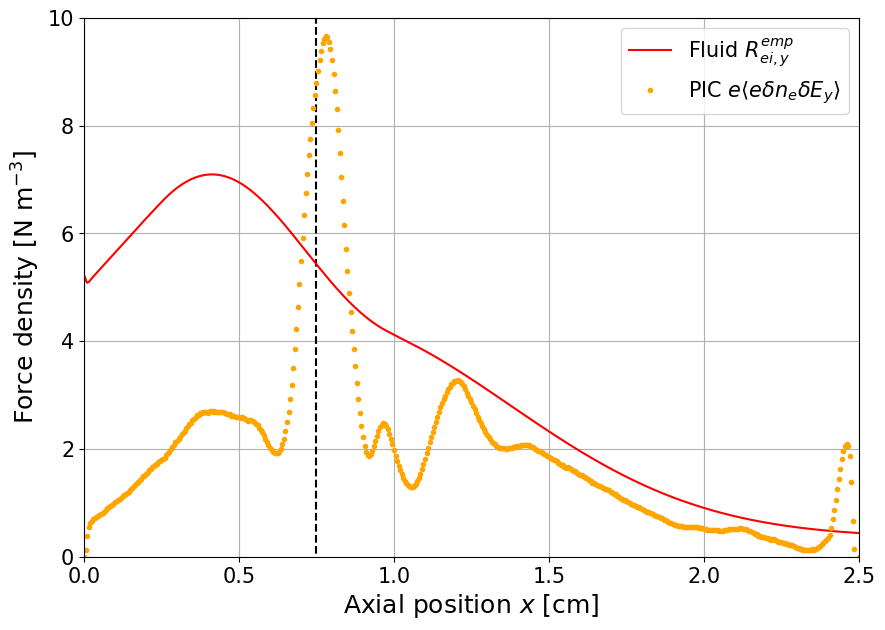

In [92]:
fig = plt.figure(figsize=(10,7))

plt.plot([LTHR*100, LTHR*100], [-2000., 2000.], 'k--')
plt.plot(x_center*100, Rei_emp_y, 'r-', label='Fluid $R_{ei,y}^{emp}$')
plt.plot(extracted_df['x'], PIC_Rei_y, '.', color='orange', label = "PIC $e \\langle e \\delta n_e \\delta E_y \\rangle$")
plt.ylim([0., 10.])
plt.xlim([0., 2.5])
plt.xlabel("Axial position $x$ [cm]", fontsize=axisfontsize)
plt.ylabel("Force density [N m$^{-3}$]", fontsize=axisfontsize)
plt.tick_params(labelsize=tickfontsize)
plt.grid()
plt.legend(fontsize=legendfontsize)
plt.show()

## Comparison of force density terms, axial projection

In [81]:
Rei_emp_x     = - phy_const.m_e * uex * ni * alpha_B * w_ce
F_in_x  = np.gradient(phy_const.m_e * ni * uex**2, x_center)
F_t_x   = phy_const.m_e * (ni*uex - Pm1[1, :] * Pm1[4, :])/(t - tm1)
F_B_x   = - phy_const.e * ni * Barr * uey
F_E_x   = - phy_const.e * Efield * ni
F_p_x   = - np.gradient(phy_const.e * ni * Te, x_center)
LHS_x   = F_in_x + F_t_x
RHS_x   = Rei_emp_x + F_B_x + F_E_x + F_p_x

In [82]:
PIC_F_in_x  = np.gradient(phy_const.m_e * extracted_df['n_e'] * extracted_df['ve_x']**2, extracted_df['x']/100)
PIC_LHS_x   = PIC_F_in_x + 0.
PIC_F_B_x       = - phy_const.e * extracted_df['n_e'] * extracted_df['BB']*100 * extracted_df['ve_y']    # Magnetic amplitude is here in Tesla. In data it was in 0.1 kT
PIC_F_E_x       = - phy_const.e * extracted_df['EE'] * extracted_df['n_e']
PIC_F_p_x       = - np.gradient(phy_const.e * extracted_df['n_e'] * extracted_df['Te_x'], extracted_df["x"]/100)
PIC_RHS_x       = PIC_F_B_x + PIC_F_E_x + PIC_F_p_x + extracted_df['corr_term_x']

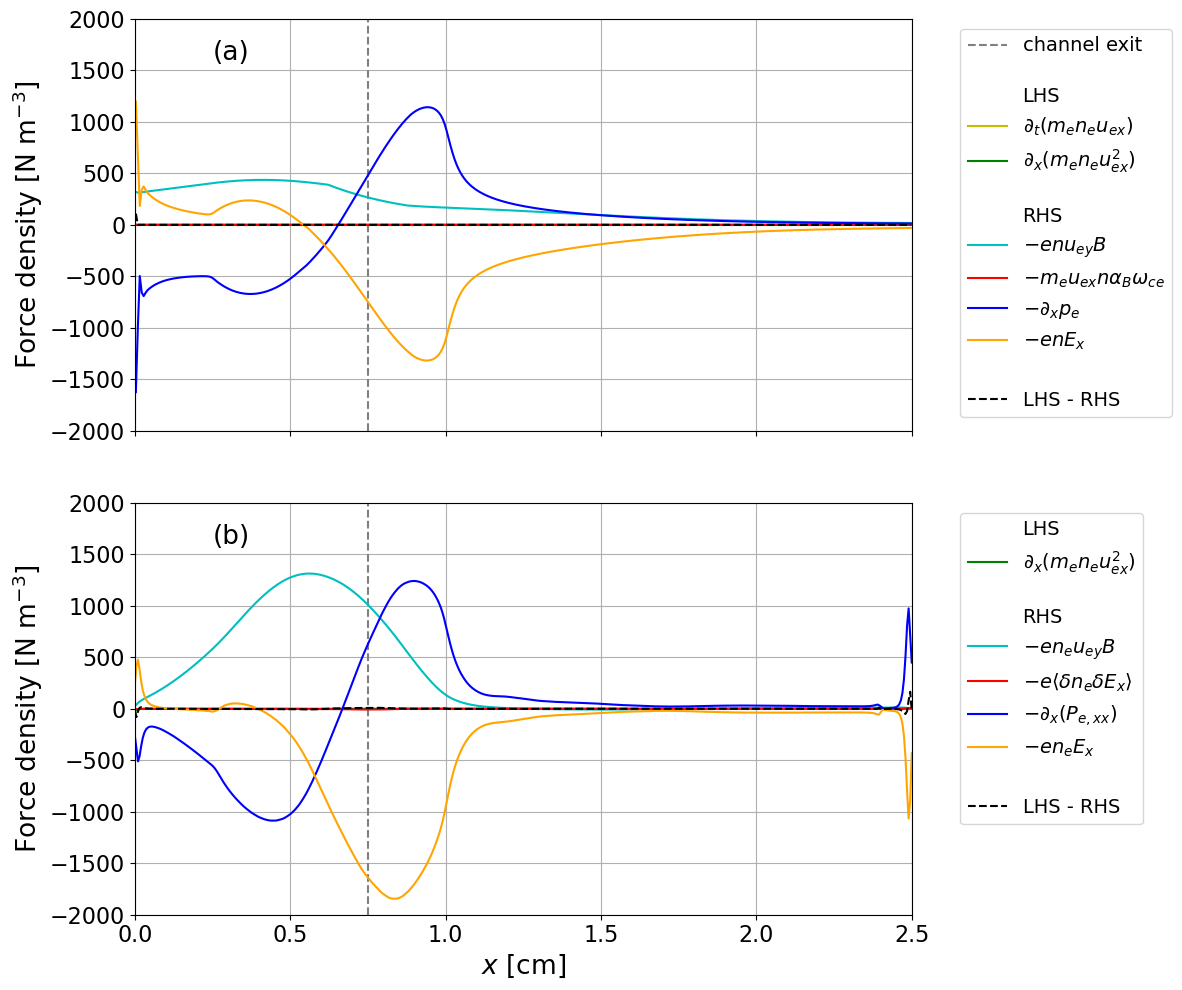

In [100]:
f, ax = plt.subplots(2, 1, figsize=(12,10))

ax[0].plot([LTHR*100, LTHR*100], [-2000., 2000.], '--', color='grey', label="channel exit")
ax[0].plot([], [], ' ', label="\nLHS")
ax[0].plot(x_center*100, F_t_x, 'y-', label = "$\\partial_t(m_e n_e u_{ex})$")
ax[0].plot(x_center*100, F_in_x, 'g-', label = "$\\partial_x(m_e n_e u_{ex}^2)$")
ax[0].plot([], [], ' ', label="\nRHS")
ax[0].plot(x_center*100, F_B_x, 'c-', label = "$-e n u_{ey} B$")
ax[0].plot(x_center*100, Rei_emp_x, 'r-', label = "$- m_e u_{ex} n \\alpha_B \\omega_{ce}$")
ax[0].plot(x_center*100, F_p_x, 'b-', label = "$-\\partial_x p_e$")
ax[0].plot(x_center*100, F_E_x, '-', color='orange', label = "$-e n E_x$")
ax[0].plot([], [], ' ', label=" ")
ax[0].plot(x_center*100, LHS_x - RHS_x, 'k--', label = "LHS - RHS")
ax[0].set_ylim([-2000., 2000.])
ax[0].set_xlim([0., 2.5])
ax[0].set_xticklabels([])
ax[0].set_ylabel("Force density [N m$^{-3}$]", fontsize=axisfontsize)
ax[0].yaxis.set_tick_params(labelsize=tickfontsize)
ax[0].grid()
ax[0].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize-1)
ax[0].text(0.25, 1600., '(a)', fontsize=axisfontsize)

ax[1].plot([LTHR*100, LTHR*100], [-2000., 2000.], '--', color='grey')
ax[1].plot([], [], ' ', label="LHS")
ax[1].plot(extracted_df['x'], PIC_F_in_x, 'g-', label = "$\\partial_x(m_e n_e u_{ex}^2)$")
ax[1].plot([], [], ' ', label="\nRHS")
ax[1].plot(extracted_df['x'], PIC_F_B_x, 'c-', label = "$-e n_e u_{ey} B$")
ax[1].plot(extracted_df['x'], extracted_df['corr_term_x'], 'r-', label = "$-e \\langle \\delta n_e \\delta E_x \\rangle$")
ax[1].plot(extracted_df['x'], PIC_F_p_x, 'b-', label = "$-\\partial_x (P_{e,xx})$")
ax[1].plot(extracted_df['x'], PIC_F_E_x, '-', color='orange', label = "$-e n_e E_x$")
ax[1].plot([], [], ' ', label=" ")
ax[1].plot(extracted_df['x'], PIC_LHS_x - PIC_RHS_x, 'k--', label = "LHS - RHS")
ax[1].set_ylim([-2000., 2000.])
ax[1].set_xlim([0., 2.5])
ax[1].set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax[1].set_ylabel("Force density [N m$^{-3}$]", fontsize=axisfontsize)
ax[1].xaxis.set_tick_params(labelsize=tickfontsize)
ax[1].yaxis.set_tick_params(labelsize=tickfontsize)
ax[1].grid()
ax[1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize-1)
ax[1].text(0.25, 1600., '(b)', fontsize=axisfontsize)

plt.tight_layout()
plt.show()

## Comparison of energy terms

In [ ]:
mu_eff = FLHET_compiled.compute_mu(P, Barr, ESTAR, wall_inter_type, R1, R2, Mi, x_center, LTHR, KEL, alpha_B)

At steady-state the model of the 1D fluid code gives:
$$
\frac{5}{2}\partial_x (n_e k_B T_e v_{ex}) = e n_e v_{ex} \frac{v_{ex}}{\mu} + v_{ex} \partial_x (n_e k_B T_e)
$$
$$
0 = P_{in,x} + P_{t,x} + P_{\mu,x} + P_{p,x}
$$
The left-hand side is an inertial term whereas the right-hand side got two source terms actually coming from the same physical cause. It is the work of the electric field (or power density given to the $e^-$ from the electric field):
$$
n_e q_e \mathbf{E} \cdot \mathbf{v_e} = e n_e v_{ex} \frac{v_{ex}}{\mu} + v_{ex} \partial_x (n_e k_B T_e)
$$
In the following, the curve right-hand side RHS is the sum of $e n_e v_{ex} \frac{v_{ex}}{\mu}$ and $v_{ex} \partial_x (n_e k_B T_e)$.

In [ ]:
P_in_x  = - 2.5 * np.gradient(phy_const.e * ni * Te * uex, x_center)
P_t_x   = - 1.5 * phy_const.e * (ni * Te - Pm1[1, :]*Pm1[3, :])/(t - tm1)
P_mu_x  = phy_const.e * ni * uex**2 / mu_eff     # e*n_e* vex^2 / mu
P_p_x   = uex * np.gradient(phy_const.e * ni * Te, x_center)
P_RHS_x = P_in_x + P_t_x + P_mu_x + P_p_x

In [ ]:
PIC_P_in_x  = - 2.5 * np.gradient(phy_const.e * extracted_df['n_e'] * extracted_df['Te_x'] * extracted_df['ve_x'], extracted_df['x']/100)
PIC_P_E_x     = - phy_const.e * extracted_df['n_e'] * extracted_df['EE'] * extracted_df['ve_x']
PIC_P_ei_x    = extracted_df['dJy_dEy']
PIC_P_RHS_x     = PIC_P_in_x + PIC_P_E_x + PIC_P_ei_x

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_6956/2957301872.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax[0].plot(x_center*100, P_mu_x/1e6, '-', label = "$P_{\mu,x}$")


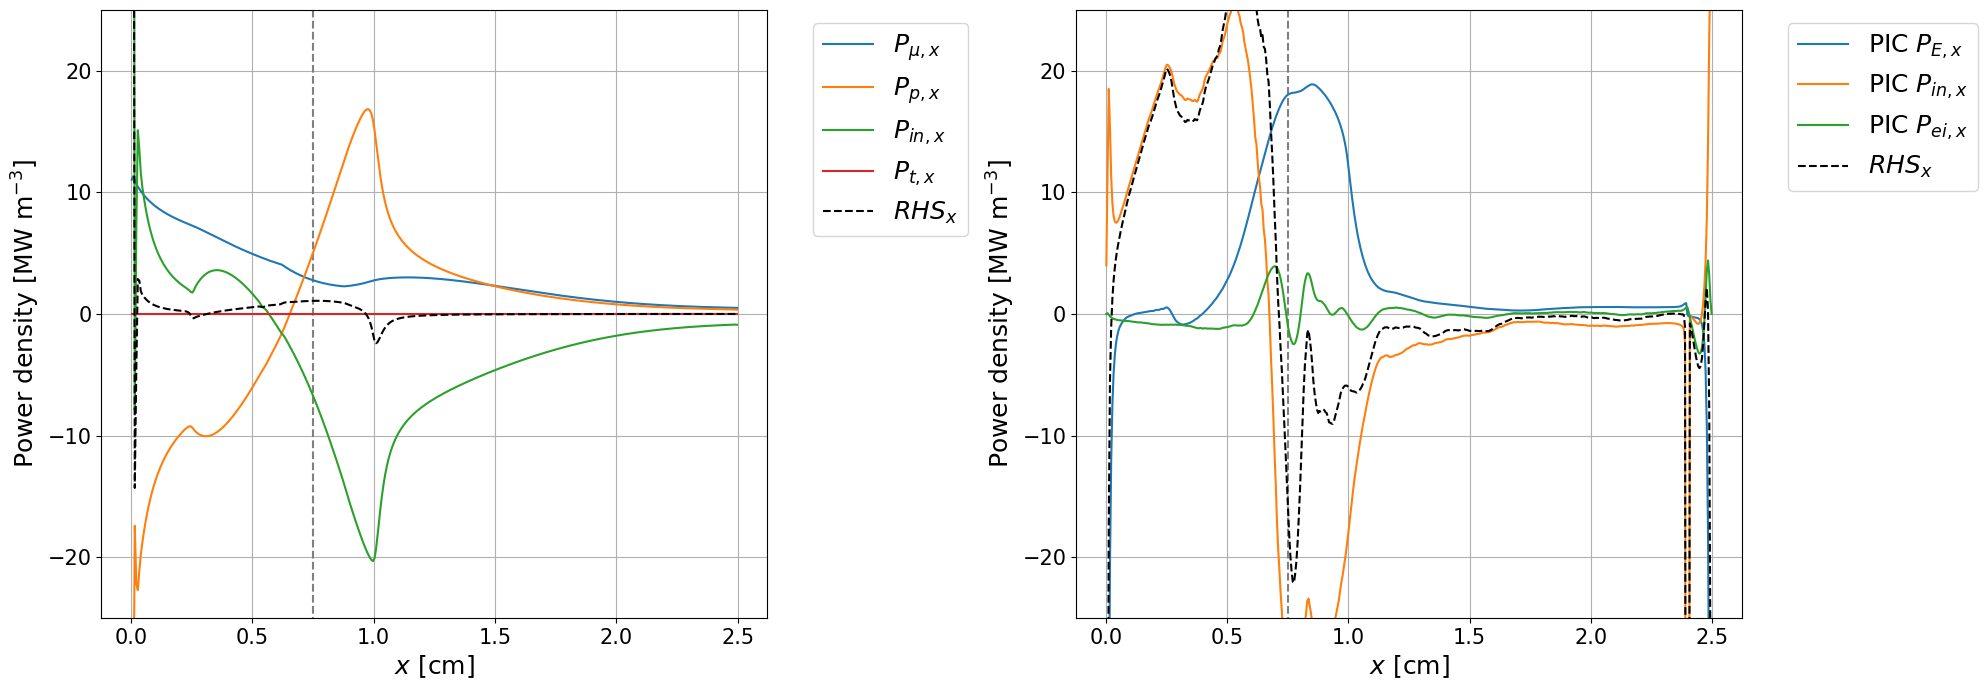

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(20,7))

ax[0].plot([LTHR*100, LTHR*100], [-50., 50.], '--', color='grey')
ax[0].plot(x_center*100, P_mu_x/1e6, '-', label = "$P_{\mu,x}$")
ax[0].plot(x_center*100, P_p_x/1e6, '-', label = "$P_{p,x}$")
ax[0].plot(x_center*100, P_in_x/1e6, '-', label = "$P_{in,x}$")
ax[0].plot(x_center*100, P_t_x/1e6, '-', label = "$P_{t,x}$")
ax[0].plot(x_center*100, P_RHS_x/1e6, 'k--', label = "$RHS_x$")
ax[0].set_ylim([-25., 25.])
ax[0].set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax[0].set_ylabel("Power density [MW m$^{-3}$]", fontsize=axisfontsize)
ax[0].xaxis.set_tick_params(labelsize=tickfontsize)
ax[0].yaxis.set_tick_params(labelsize=tickfontsize)
ax[0].grid()
ax[0].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)

ax[1].plot([LTHR*100, LTHR*100], [-50., 50.], '--', color='grey')
ax[1].plot(extracted_df['x'], PIC_P_E_x/1e6, '-', label = "PIC $P_{E,x}$")
ax[1].plot(extracted_df['x'], PIC_P_in_x/1e6, '-', label = "PIC $P_{in,x}$")
ax[1].plot(extracted_df['x'], PIC_P_ei_x/1e6, '-', label = "PIC $P_{ei,x}$")
ax[1].plot(extracted_df['x'], PIC_P_RHS_x/1e6, 'k--', label = "$RHS_x$")
ax[1].set_ylim([-25., 25.])
ax[1].set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax[1].set_ylabel("Power density [MW m$^{-3}$]", fontsize=axisfontsize)
ax[1].xaxis.set_tick_params(labelsize=tickfontsize)
ax[1].yaxis.set_tick_params(labelsize=tickfontsize)
ax[1].grid()
ax[1].legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)

plt.tight_layout()
plt.show()

Resultat bizarre pour le terme interiel venant de PIC donc zoom sur e facteur v_ex.

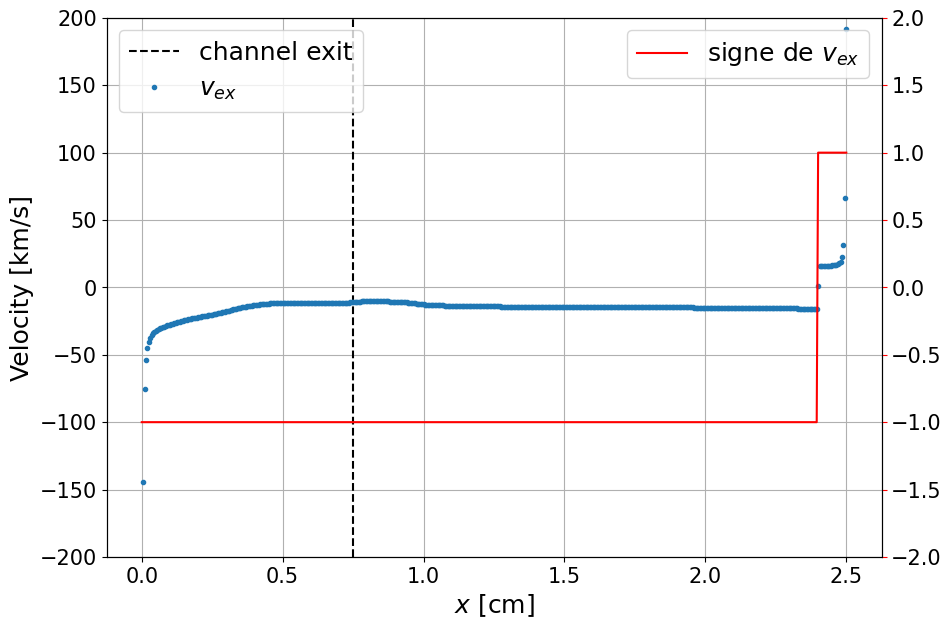

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax_b = ax.twinx()
ax.plot([LTHR*100, LTHR*100], [-200., 200.], 'k--', label = "channel exit")
ax.plot(extracted_df['x'], extracted_df['ve_x']/1e3, '.', label="$v_{ex}$")
ax.set_ylim([-200., 200.])
ax_b.plot(extracted_df['x'], np.sign(extracted_df['ve_x']), 'r-', label="signe de $v_{ex}$")
ax_b.set_ylim([-2, 2])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Velocity [km/s]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)
ax_b.yaxis.set_tick_params(labelsize=tickfontsize, color='r')

ax.grid()
ax.legend(loc="upper left", fontsize=legendfontsize)
ax_b.legend(loc='upper right', fontsize=legendfontsize)
plt.show()

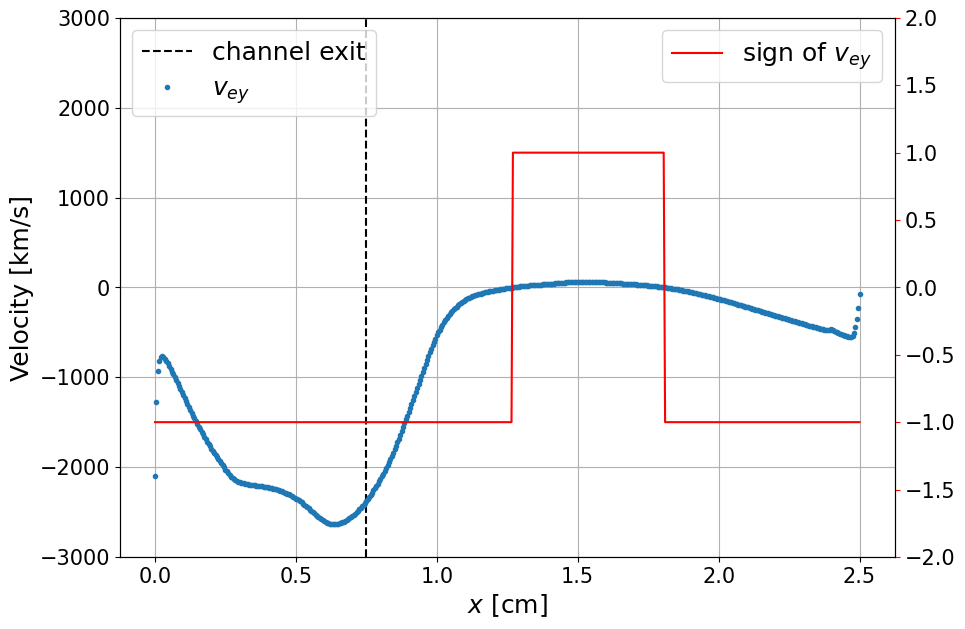

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax_b = ax.twinx()
ax.plot([LTHR*100, LTHR*100], [-3000., 3000.], 'k--', label = "channel exit")
ax.plot(extracted_df['x'], extracted_df['ve_y']/1e3, '.', label="$v_{ey}$")
ax.set_ylim([-3000., 3000.])
ax_b.plot(extracted_df['x'], np.sign(extracted_df['ve_y']), 'r-', label="sign of $v_{ey}$")
ax_b.set_ylim([-2, 2])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Velocity [km/s]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)
ax_b.yaxis.set_tick_params(labelsize=tickfontsize, color='r')

ax.grid()
ax.legend(loc="upper left", fontsize=legendfontsize)
ax_b.legend(loc='upper right', fontsize=legendfontsize)
plt.show()

## What $\nu_{anom}$ is needed to achieve the same friction force as $e\langle \delta n_e \delta E_y \rangle$

We want to find the anomalous freq. achieving the right frction force density:
$$
R_{ei}^{emp}(x) = e\langle \delta n_e \delta E_y \rangle
$$
$$
\Leftrightarrow -m_e v_{ey} n_e \nu_{anom} = e\langle \delta n_e \delta E_y \rangle
$$
$$
\Leftrightarrow \nu_{anom} = -\frac{e}{m_e}\frac{\langle \delta n_e \delta E_y \rangle}{v_{ey} n_e}
$$



Numerically, we would need a new equation in the fluid model that is:

$
\nu_{anom}^{n+1} = \frac{e}{m_e}\frac{\langle \delta n_e \delta E_y \rangle^{*}}{(-v_{ey}^n) n_e^n }
$

Where * means from PIC and constant during the fluid simlation.

### In terms of $\alpha_B$ (obsolete)

In [ ]:
function_corr_term = interpolate.interp1d(extracted_df['x'], extracted_df['corr_term_y']/(phy_const.e* (-extracted_df['ve_y']) * extracted_df['n_e']), bounds_error=False)
new_corr_term = function_corr_term(x_center*100)
RHS_alphaB = new_corr_term/Barr

In [ ]:
RHS_alphaB

array([ 1.82293013e-03,  6.12820933e-03,  7.71761568e-03,  7.62973493e-03,
        7.27062932e-03,  6.79091061e-03,  6.37657483e-03,  6.07706059e-03,
        5.82005576e-03,  5.58035823e-03,  5.37052627e-03,  5.27956839e-03,
        5.12033997e-03,  4.99195829e-03,  4.83078401e-03,  4.68302870e-03,
        4.56351987e-03,  4.45469237e-03,  4.29727487e-03,  4.17943460e-03,
        4.08845881e-03,  4.01389180e-03,  3.90929897e-03,  3.84559580e-03,
        3.80497073e-03,  3.74855972e-03,  3.69276317e-03,  3.65987513e-03,
        3.61080974e-03,  3.55475346e-03,  3.53218547e-03,  3.46128136e-03,
        3.43164917e-03,  3.40222647e-03,  3.33685764e-03,  3.30591112e-03,
        3.23953901e-03,  3.20035543e-03,  3.16268522e-03,  3.10283258e-03,
        3.06566208e-03,  3.01495859e-03,  3.01506378e-03,  2.98531928e-03,
        2.96547675e-03,  2.95747087e-03,  2.95086610e-03,  2.93329132e-03,
        2.90755478e-03,  2.89108679e-03,  2.87708417e-03,  2.85538958e-03,
        2.84325158e-03,  

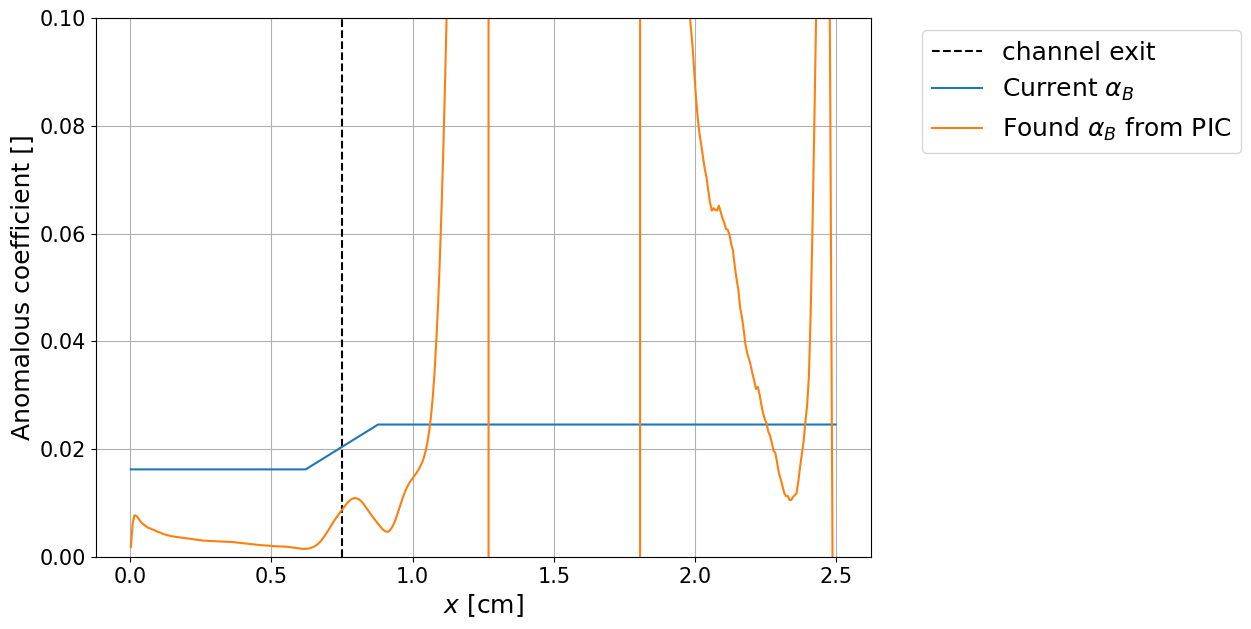

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot([LTHR*100, LTHR*100], [0., 1.], 'k--', label = "channel exit")
ax.plot(x_center*100, alpha_B, '-', label = "Current $\\alpha_B$")
ax.plot(x_center*100, RHS_alphaB, '-', label = "Found $\\alpha_B$ from PIC")

ax.set_ylim([0., 0.1])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous coefficient []", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

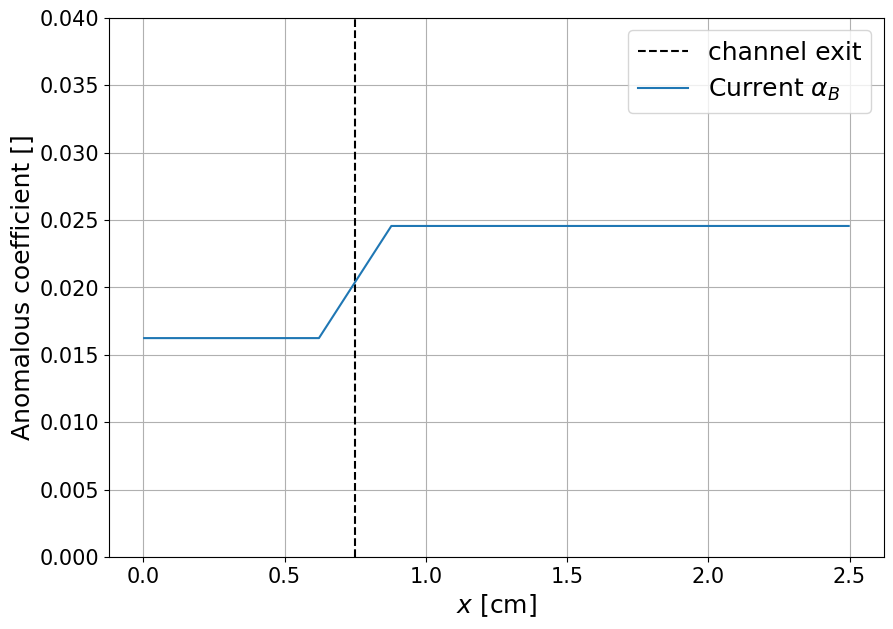

In [19]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.plot(x_center*100, alpha_B, '-', label = "Current $\\alpha_B$")
ax.set_ylim([0., 4e-2])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous coefficient []", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(fontsize=legendfontsize)
plt.show()

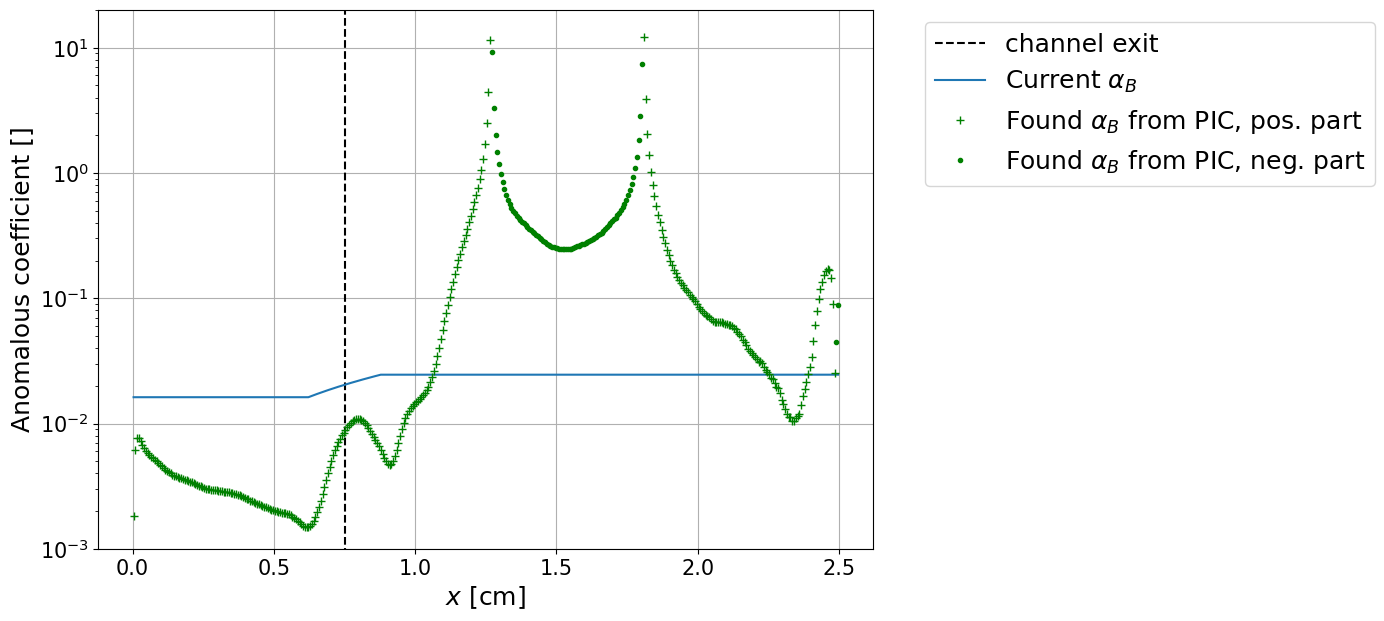

In [ ]:
RHS_alphaB_plus = RHS_alphaB[np.argwhere(RHS_alphaB > 0.)]
x_center_plus   = x_center[np.argwhere(RHS_alphaB > 0.)]

RHS_alphaB_minus = RHS_alphaB[np.argwhere(RHS_alphaB < 0.)]
x_center_minus   = x_center[np.argwhere(RHS_alphaB < 0.)]

f, ax = plt.subplots(figsize=(10,7))

ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, alpha_B, '-', label = "Current $\\alpha_B$")
ax.semilogy(x_center_plus*100, RHS_alphaB_plus, 'g+', label = "Found $\\alpha_B$ from PIC, pos. part")
ax.semilogy(x_center_minus*100, -RHS_alphaB_minus, 'g.', label = "Found $\\alpha_B$ from PIC, neg. part")
ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous coefficient []", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

### In terms of $\nu_{anom}$

In [ ]:
full_PIC_nu = (1/phy_const.m_e)*extracted_df['corr_term_y']/(- extracted_df['ve_y'] * extracted_df['n_e'])
full_PIC_nu = np.array(full_PIC_nu)
PIC_x       = np.array(extracted_df['x'])

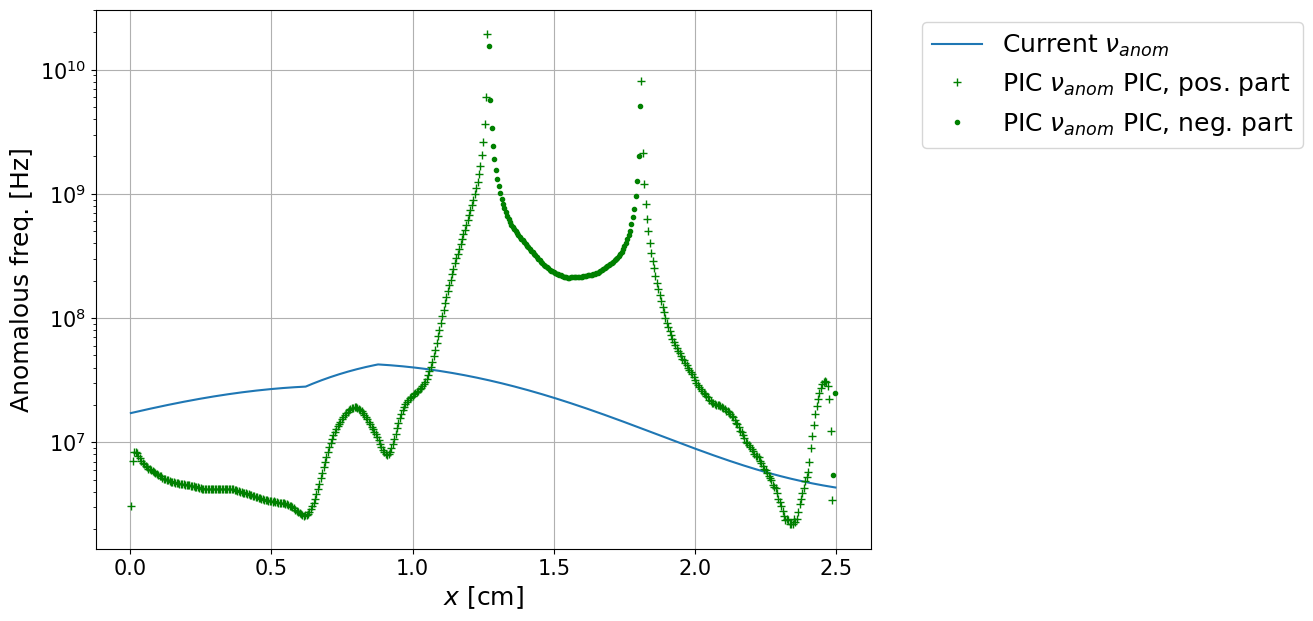

In [ ]:
current_nu  = alpha_B * (phy_const.e/phy_const.m_e) * Barr

PIC_nu_plus = full_PIC_nu[np.argwhere(full_PIC_nu > 0.)]
PIC_x_plus   = PIC_x[np.argwhere(full_PIC_nu > 0.)]

PIC_nu_minus = full_PIC_nu[np.argwhere(full_PIC_nu < 0.)]
PIC_x_minus   = PIC_x[np.argwhere(full_PIC_nu < 0.)]

f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, current_nu, '-', label = "Current $\\nu_{anom}$")
ax.semilogy(PIC_x_plus, PIC_nu_plus, 'g+', label = "PIC $\\nu_{anom}$ PIC, pos. part")
ax.semilogy(PIC_x_minus, -PIC_nu_minus, 'g.', label = "PIC $\\nu_{anom}$ PIC, neg. part")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. [Hz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

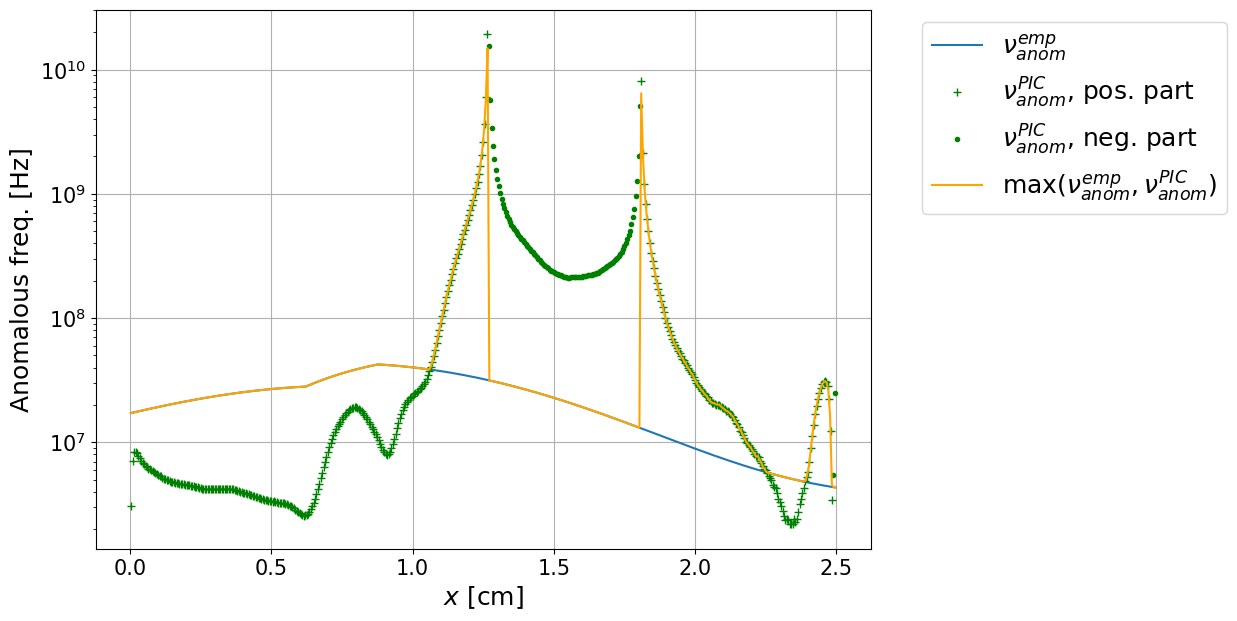

In [ ]:
PIC_nu_f    = interpolate.interp1d(PIC_x/100, full_PIC_nu)
full_PIC_nu_x_center    = PIC_nu_f(x_center)
maxempPIC_nu    = np.maximum(current_nu, full_PIC_nu_x_center)

f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, current_nu, '-', label = "$\\nu_{anom}^{emp}$")
ax.semilogy(PIC_x_plus, PIC_nu_plus, 'g+', label = "$\\nu_{anom}^{PIC}$, pos. part")
ax.semilogy(PIC_x_minus, -PIC_nu_minus, 'g.', label = "$\\nu_{anom}^{PIC}$, neg. part")
ax.semilogy(x_center*100, maxempPIC_nu, '-', color='orange', label="$\\max (\\nu_{anom}^{emp}, \\nu_{anom}^{PIC})$")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. [Hz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
# Saves this anomalous freq. to a .csv file
df_to_save_0 = pd.DataFrame({'x[cm]':PIC_x, 'nu_anom[Hz]':full_PIC_nu})
df_to_save_0.to_csv("./Inputs/nu_anom_arrays/full_PIC_nu.csv", sep='\t', float_format="%.6e")

In [ ]:
indices_boundary_positives = []
last_index_is_pos = (full_PIC_nu[0] > 0.)
foundEvenNumberOfPts = True
for i in range(1, full_PIC_nu.shape[0]):
    if full_PIC_nu[i] <= 0.:
        if last_index_is_pos:
            indices_boundary_positives.append(i-1)
            last_index_is_pos = False
            foundEvenNumberOfPts = not foundEvenNumberOfPts
    else:
        if not last_index_is_pos:
            indices_boundary_positives.append(i)
            last_index_is_pos = True
            foundEvenNumberOfPts = not foundEvenNumberOfPts

new_nu_1 = np.copy(full_PIC_nu)

if full_PIC_nu[0] <= 0.:
    first_i = indices_boundary_positives.pop(0)
    new_nu_1[0 : first_i] = full_PIC_nu[first_i]

if full_PIC_nu[-1] <= 0.:
    last_i = indices_boundary_positives.pop()
    new_nu_1[last_i+1:] = full_PIC_nu[last_i]     

if len(indices_boundary_positives) > 0:
    assert( len(indices_boundary_positives) % 2 == 0)
    while len(indices_boundary_positives) > 0:

        i2 = indices_boundary_positives.pop()
        i1 = indices_boundary_positives.pop()
        x2 = PIC_x[i2]
        x1 = PIC_x[i1]
        nu2 = full_PIC_nu[i2]
        nu1 = full_PIC_nu[i1]
        slope = (nu2 - nu1)/(x2 - x1)

        new_nu_1[i1:i2] = nu1 + (PIC_x[i1:i2] - x1)*slope

In [ ]:
corr_term_interp_f  = interpolate.interp1d(extracted_df['x']/100.0, extracted_df['corr_term'])
corr_term_interp    = corr_term_interp_f(x_center)
current_nu  = alpha_B * (phy_const.e/phy_const.m_e) * Barr
hybrid_nu   = (corr_term_interp * alpha_B) / ( phy_const.m_e *(- P[4,:]) * P[1,:])
hybrid_nu   = np.where( hybrid_nu >= 0., hybrid_nu, 0.)

KeyError: 'corr_term'

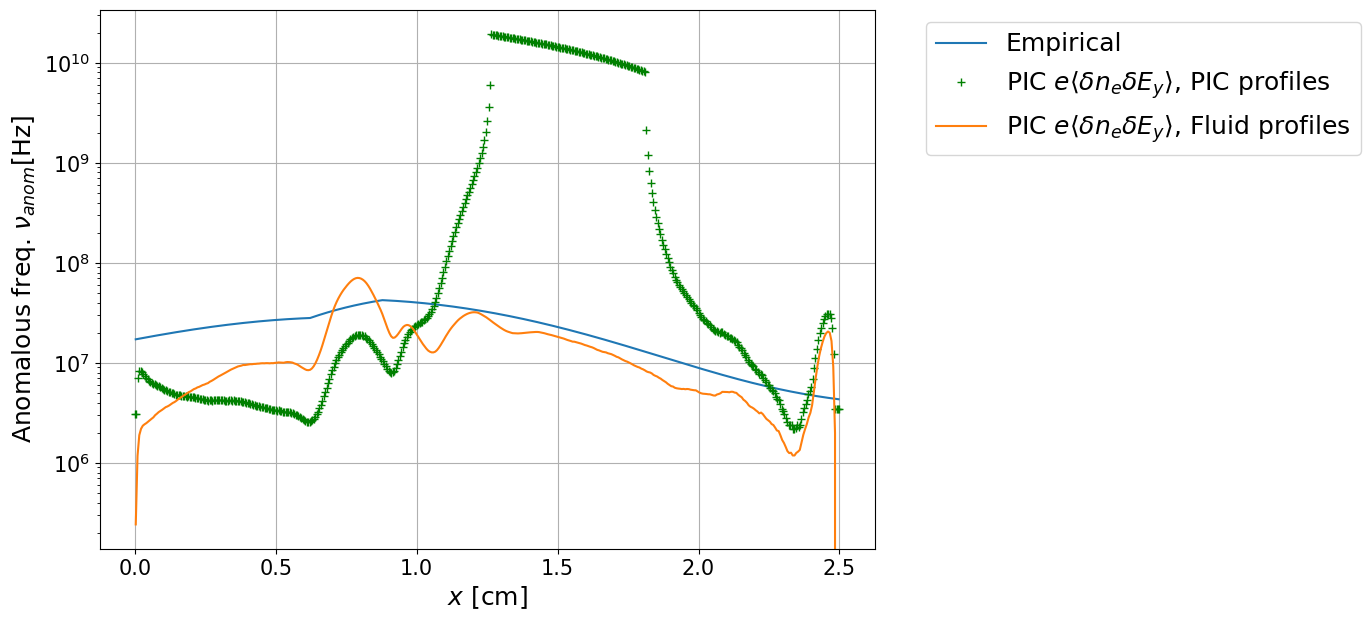

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, current_nu, '-', label = "Empirical")
ax.semilogy(PIC_x, new_nu_1, 'g+', label = "PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, PIC profiles")
ax.semilogy(x_center*100, hybrid_nu, '-', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, Fluid profiles")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. $\\nu_{anom}$[Hz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

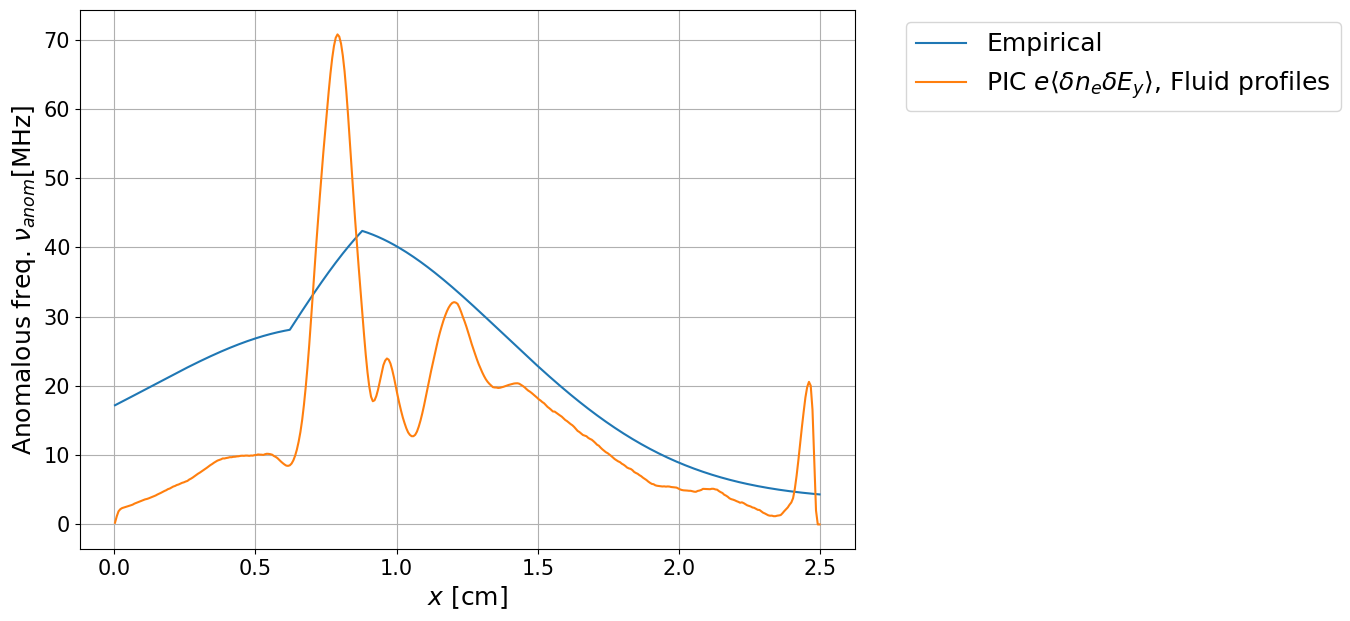

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.plot(x_center*100, current_nu/1e6, '-', label = "Empirical")
ax.plot(x_center*100, hybrid_nu/1e6, '-', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, Fluid profiles")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. $\\nu_{anom}$ [MHz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
index_neg   = np.argwhere(hybrid_nu < 0.)
print(index_neg)
avg_current_hybrid_nu   = np.where(hybrid_nu >= current_nu, hybrid_nu, 0.5*(hybrid_nu + current_nu))

[]


In [ ]:
max_current_hybrid_nu   = np.maximum(hybrid_nu, current_nu)

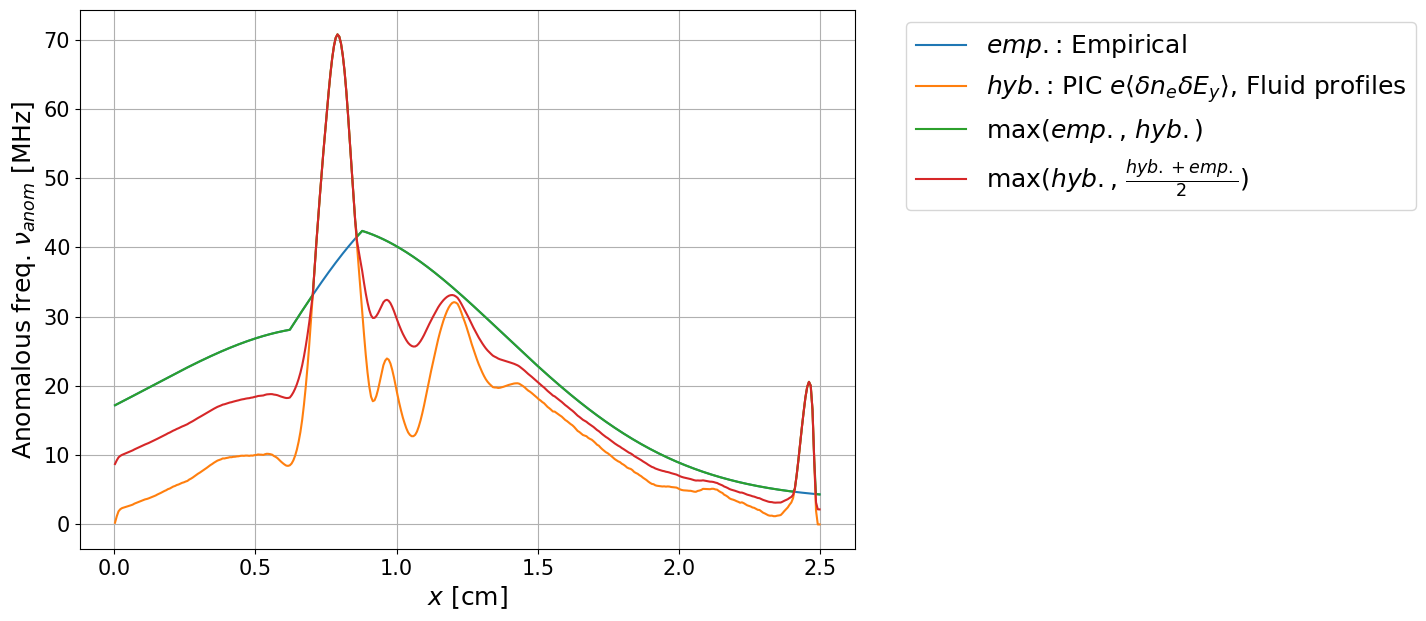

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.plot(x_center*100, current_nu/1e6, '-', label = "$emp.$: Empirical")
ax.plot(x_center*100, hybrid_nu/1e6, '-', label="$hyb.$: PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, Fluid profiles")
ax.plot(x_center*100, max_current_hybrid_nu/1e6, '-', label="max($emp.$, $hyb.$)")
ax.plot(x_center*100, avg_current_hybrid_nu/1e6, '-', label="max($hyb.$, $\\frac{hyb. + emp.}{2}$)")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. $\\nu_{anom}$ [MHz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
df_to_save_1 = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':hybrid_nu})
df_to_save_1.to_csv("Inputs/nu_anom_arrays/hybrid_nu_anom.csv", sep='\t', float_format="%.6e")

In [ ]:
df_to_save_2 = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':avg_current_hybrid_nu})
df_to_save_2.to_csv("Inputs/nu_anom_arrays/avg_emp_hybrid_nu_anom.csv", sep='\t', float_format="%.6e")

In [ ]:
df_to_save_3 = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':max_current_hybrid_nu})
df_to_save_3.to_csv("Inputs/nu_anom_arrays/max_emp_hybrid_nu_anom.csv", sep='\t', float_format="%.6e")

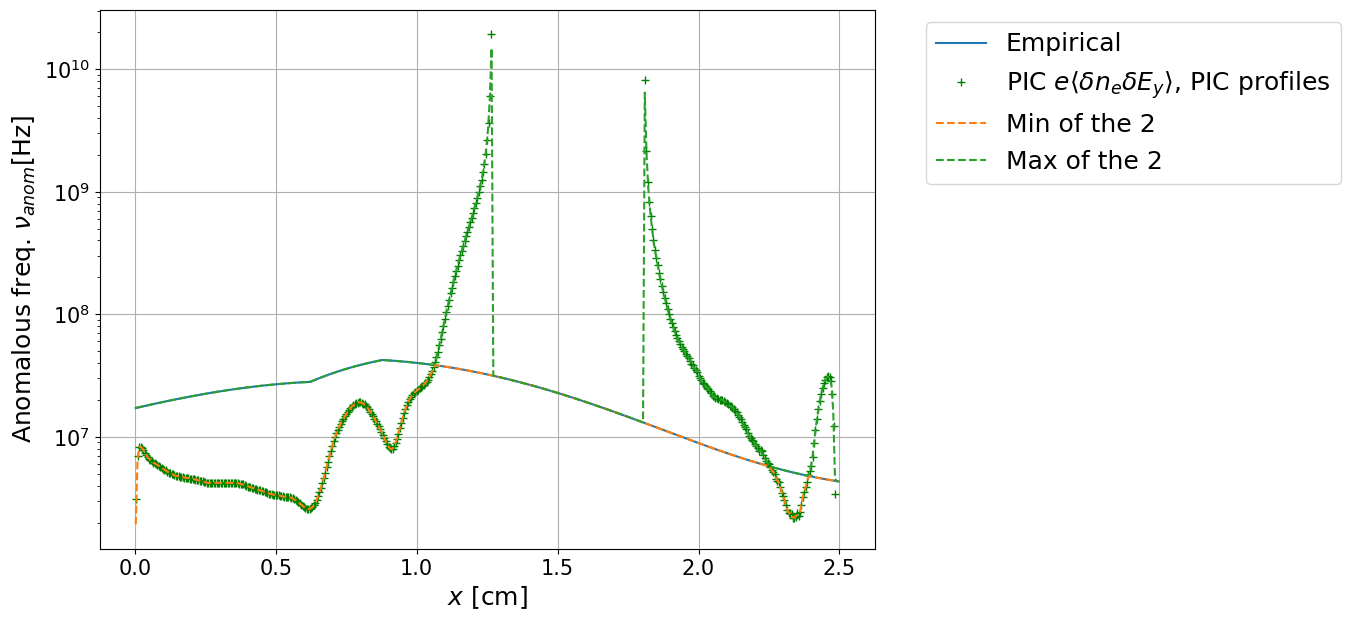

In [ ]:
PIC_nu_f    = interpolate.interp1d(PIC_x/100, full_PIC_nu)
PIC_nu_N400     = PIC_nu_f(x_center)
min_emp_PIC_nu  = np.minimum(current_nu, np.abs(PIC_nu_N400))
max_emp_PIC_nu  = np.maximum(current_nu, PIC_nu_N400)

f, ax = plt.subplots(figsize=(10,7))

#ax.semilogy([LTHR*100, LTHR*100], [1e-5, 100.], 'k--', label = "channel exit")
ax.semilogy(x_center*100, current_nu, '-', label = "Empirical")
ax.semilogy(PIC_x, full_PIC_nu, 'g+', label = "PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, PIC profiles")
ax.semilogy(x_center*100, min_emp_PIC_nu, '--', label="Min of the 2")
ax.semilogy(x_center*100, max_emp_PIC_nu, '--', label="Max of the 2")
#ax.set_ylim([1e-3, 20.])
ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous freq. $\\nu_{anom}$[Hz]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
df_to_save_4 = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':min_emp_PIC_nu})
df_to_save_4.to_csv("Inputs/nu_anom_arrays/min_emp_PIC_nu_anom.csv", sep='\t', float_format="%.6e")

In [ ]:
df_to_save_5 = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':max_emp_PIC_nu})
df_to_save_5.to_csv("Inputs/nu_anom_arrays/max_emp_PIC_nu_anom.csv", sep='\t', float_format="%.6e")

In [ ]:
current_Rei = Rei_emp_arr
hybrid_Rei  = - phy_const.m_e * (P[4,:]/alpha_B) * P[1,:] * hybrid_nu
azimuthal_flux_f    = interpolate.interp1d(extracted_df['ve_y'] * extracted_df['n_e'], extracted_df['x']/100)
azimuthal_flux      = azimuthal_flux_f(x_center)
full_PIC_Rei         = - phy_const.m_e * extracted_df['ve_y'] * extracted_df['n_e'] * new_nu_1

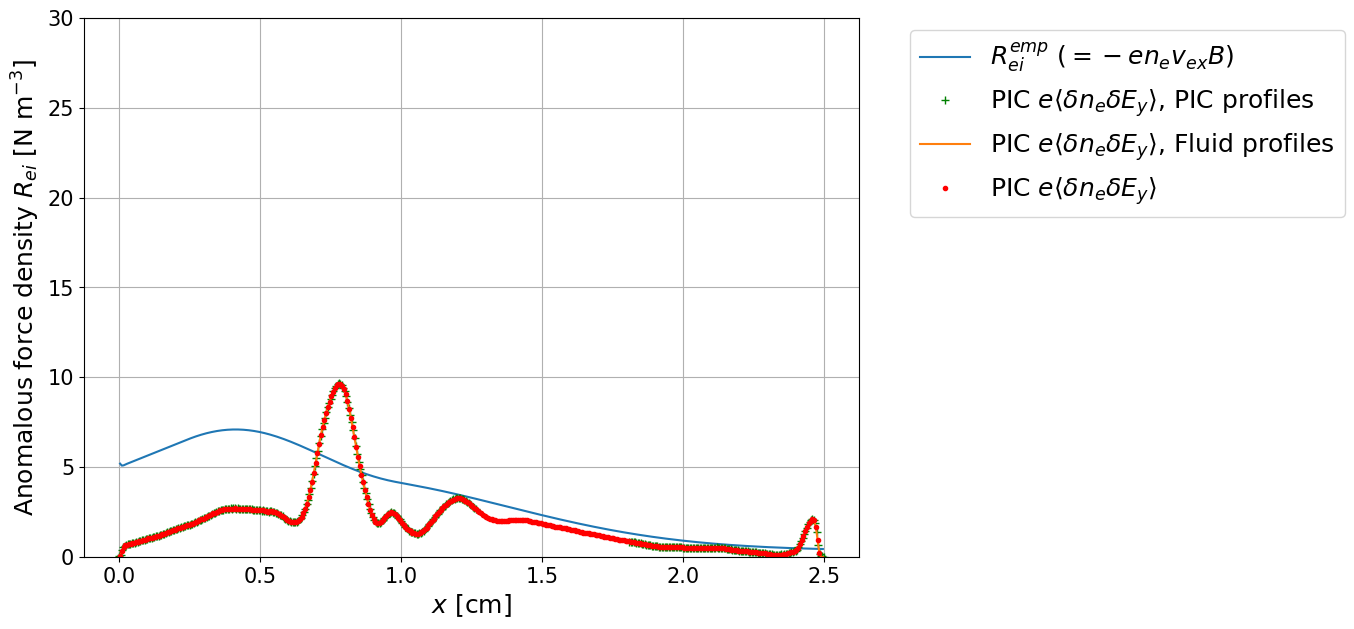

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, current_Rei, '-', label = "$R_{ei}^{emp}$ ($=-e n_e v_{ex} B$)")
ax.plot(extracted_df['x'], full_PIC_Rei, 'g+', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, PIC profiles")
ax.plot(x_center*100, hybrid_Rei, '-', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$, Fluid profiles")
ax.plot(x_center*100, corr_term_interp, 'r.', label="PIC $e\\langle \\delta n_e \\delta E_y \\rangle$")

ax.set_ylim([0., 30.])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("Anomalous force density $R_{ei}$ [N m$^{-3}$]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

In [ ]:
full_PIC_nu_almost_pos  = np.where(full_PIC_nu > 0., full_PIC_nu, 1e-10)
interp_f    = interpolate.interp1d(extracted_df['x']/100, full_PIC_nu_almost_pos)
full_PIC_nu_almost_pos  = interp_f(x_center)
df_to_save_2    = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':full_PIC_nu_almost_pos})
df_to_save_2.to_csv("Inputs/nu_anom_arrays/nu_anom_extracted_2.csv", sep='\t', float_format="%.6e")

In [ ]:
abs_full_PIC_nu = np.abs(full_PIC_nu)
interp_f    = interpolate.interp1d(extracted_df['x']/100, abs_full_PIC_nu)
abs_full_PIC_nu  = interp_f(x_center)
df_to_save_3    = pd.DataFrame({'x[cm]':x_center*100, 'nu_anom[Hz]':abs_full_PIC_nu})
df_to_save_3.to_csv("Inputs/nu_anom_arrays/abs_full_PIC_nu.csv", sep='\t', float_format="%.6e")

Drifts formulae:
$$
\mathbf{V_d} = \frac{1}{q}\frac{\mathbf{F} \times \mathbf{B}}{B^2}
$$

### Determining another way the $\nu_{anom}$

In [ ]:
omega_ce    = (phy_const.e/phy_const.m_e)*Barr
PIC_ratio   = extracted_df['corr_term']/(phy_const.e * extracted_df['n_e'] * extracted_df['EE'])
PIC_ratio_f = interpolate.interp1d(extracted_df['x']/100, PIC_ratio)
PIC_ratio   = PIC_ratio_f(x_center)
a   = PIC_ratio/omega_ce

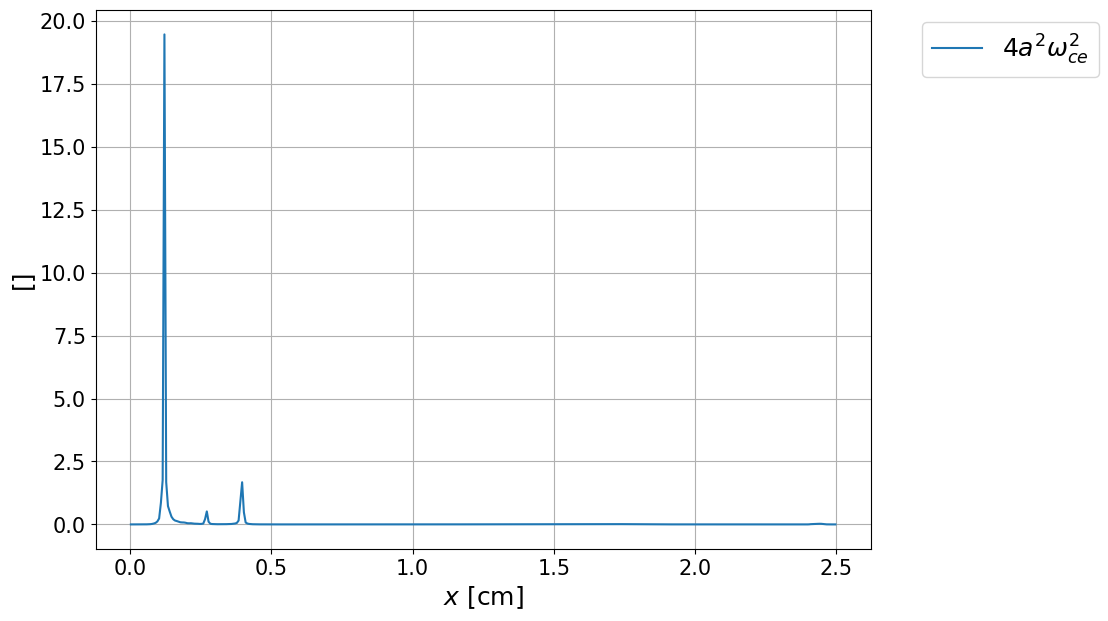

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, 4*a**2*omega_ce**2, '-', label = "$4 a^2 \\omega_{ce}^2$")

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("[]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

# Comparison of macroscopic prfiles with F.P. data 

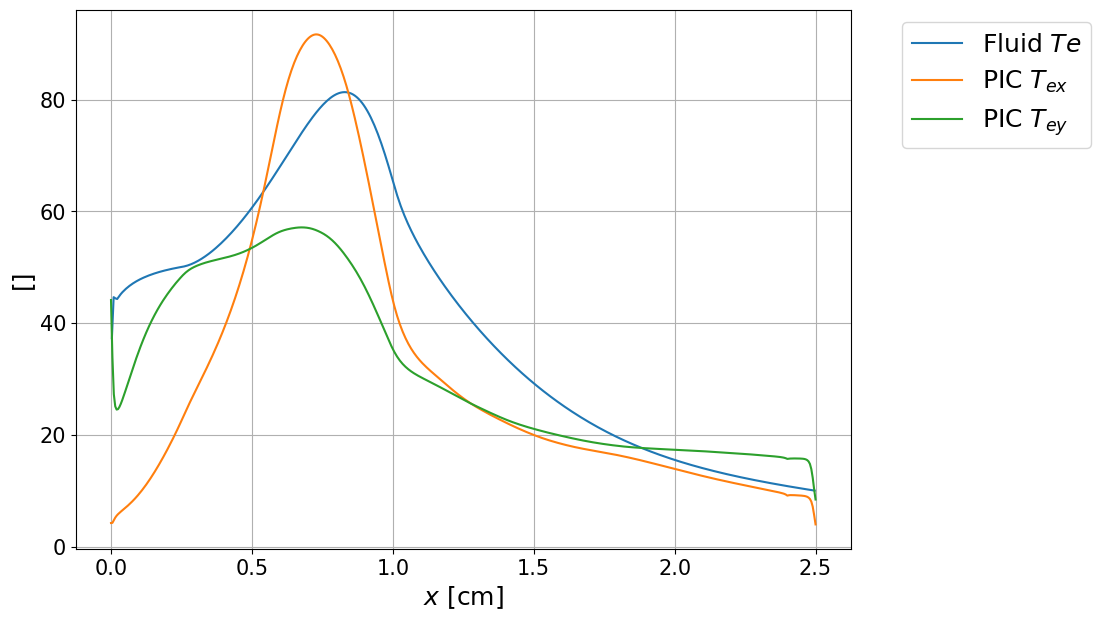

In [ ]:
f, ax = plt.subplots(figsize=(10,7))

#ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, Te, '-', label = "Fluid $Te$")
ax.plot(extracted_df['x'], extracted_df['Te_x'], label="PIC $T_{ex}$")
ax.plot(extracted_df['x'], extracted_df['Te_y'], label="PIC $T_{ey}$")

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("$T_e$ [eV]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), fontsize=legendfontsize)
plt.show()

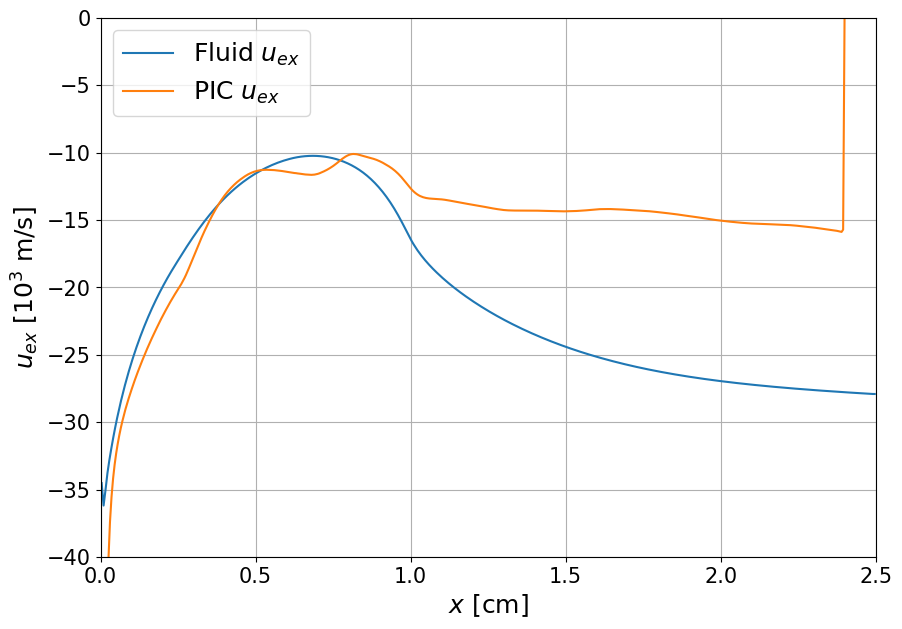

In [21]:
f, ax = plt.subplots(figsize=(10,7))

#ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, uex/1e3, '-', label = "Fluid $u_{ex}$")
ax.plot(extracted_df['x'], extracted_df['ve_x']/1e3, label="PIC $u_{ex}$")
ax.set_ylim([-40., 0.])
ax.set_xlim([0., 2.5])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("$u_{ex}$ [10$^3$ m/s]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(fontsize=legendfontsize)
plt.show()

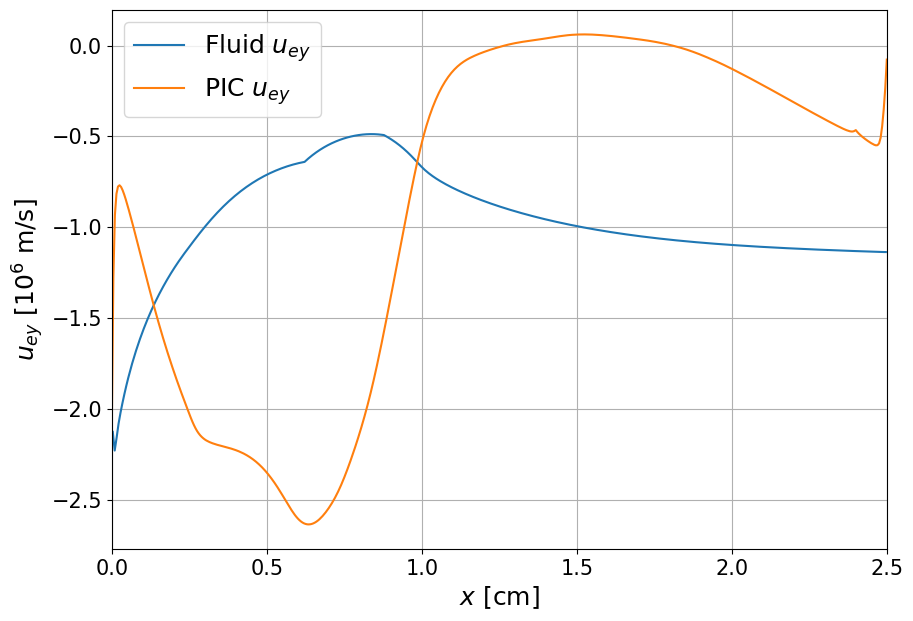

In [22]:
f, ax = plt.subplots(figsize=(10,7))

#ax.plot([LTHR*100, LTHR*100], [-50., 50.], 'k--', label = "channel exit")
ax.plot(x_center*100, uey/1e6, '-', label = "Fluid $u_{ey}$")
ax.plot(extracted_df['x'], extracted_df['ve_y']/1e6, label="PIC $u_{ey}$")
#ax.set_ylim([-40000., 40000.])
ax.set_xlim([0., 2.5])

ax.set_xlabel("$x$ [cm]", fontsize=axisfontsize)
ax.set_ylabel("$u_{ey}$ [10$^6$ m/s]", fontsize=axisfontsize)
ax.xaxis.set_tick_params(labelsize=tickfontsize)
ax.yaxis.set_tick_params(labelsize=tickfontsize)

ax.grid()
ax.legend(fontsize=legendfontsize)
plt.show()

# Comparison of the heat flux from PIC and the fluid heat flux

## Extraction of the fluid data

In [ ]:
fluid_dir   = "./Results/charoy_checkcase_0_N400_expl_hflux_no_coll_from_input"

unvariant_data_file     = fluid_dir + "/Data/MacroscopicUnvariants.pkl"
steady_stat_file        = fluid_dir + "/Data/MacroscopicVars_000087.pkl"

with open(unvariant_data_file, 'rb') as f:
    [Barr, x_mesh, x_center, alpha_B] = pickle.load(f)
Delta_x = x_mesh[1:] - x_mesh[:-1]
x_center_extended = np.insert(x_center, 0, -x_center[0])
x_center_extended = np.append(x_center_extended, x_center[-1] + Delta_x[-1])

with open(steady_stat_file, 'rb') as f:
    [t, P, U, P_LeftGhost, P_RightGhost, J, Efield] = pickle.load(f)

msp     = SimuParameters(fluid_dir + "/Configuration.cfg")

LTHR    = msp.LTHR
ESTAR   = msp.ESTAR
wall_inter_type     = msp.wall_inter_type
R1  = msp.R1
R2  = msp.R2
Mi  = msp.Mi
KEL = msp.KEL

NBPOINTS = np.shape(x_center)[0]

Default Magnetic Field
The ionization source term is imposed as specified in T.Charoy's thesis, section 2.2.2.


In [ ]:
# computing the fluid heat flux
fluid_q = mplt_mod.compute_heat_flux(np.concatenate([P_LeftGhost, P, P_RightGhost], axis=1),  np.concatenate([[Barr[0]], Barr, [Barr[-1]]]), ESTAR, wall_inter_type, R1, R2, Mi, x_center_extended, LTHR, KEL, np.concatenate([[alpha_B[0]], alpha_B, [alpha_B[-1]]]))

## Extraction of the PIC dataframe

In [ ]:
q_df = pd.read_csv("./Inputs/20240717_PIC_PAmadio/heat_flux_df.csv", sep='\t', header=0)

## Comparison with chart

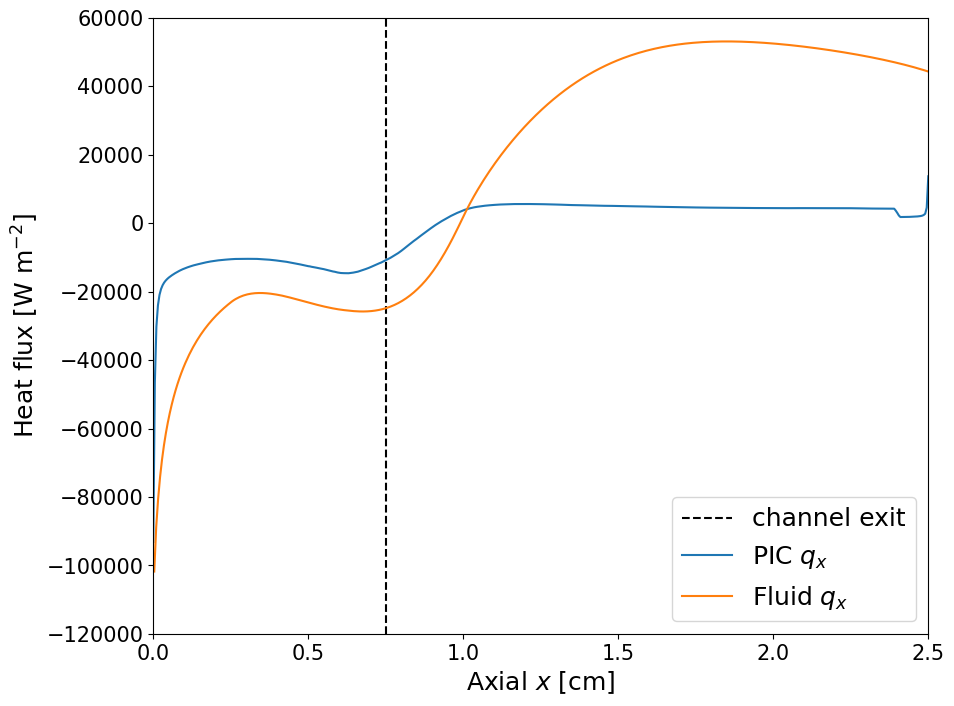

In [ ]:
fig     = plt.figure(figsize=(10,8))
plt.plot([LTHR*100, LTHR*100],[-120000.0, 60000.0], 'k--', label="channel exit")
plt.plot(q_df['x[cm]'], q_df['q_x[W/m2]'], '-', label="PIC $q_x$")
plt.plot(x_center*100, fluid_q, '-', label="Fluid $q_x$")
plt.xlim([0., 2.5])
plt.ylim([-120000.0, 60000.0])
plt.xticks(fontsize=tickfontsize)
plt.yticks(fontsize=tickfontsize)
plt.xlabel("Axial $x$ [cm]", fontsize=axisfontsize)
plt.ylabel("Heat flux [W m$^{-2}$]", fontsize=axisfontsize)
plt.legend(fontsize=legendfontsize)
plt.show()